# Part 1. Eigenface for face recognition

## Importing required packages

In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from scipy import misc
import cv2
import numpy as np
from numpy.linalg import eig
from scipy.stats import multivariate_normal
from scipy.stats import norm
import copy
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")

## Loading the Training Dataset

(540, 2500) (540,)


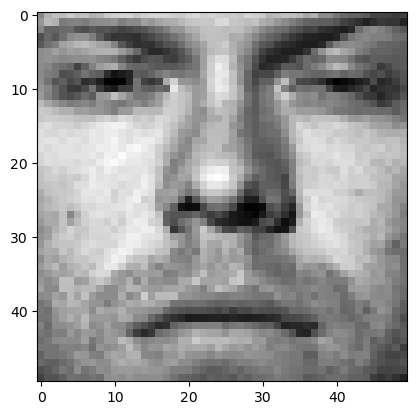

In [2]:
#Load traningin set into matrix X
#Size of X should be 540 x 2500

train_labels, train_data = [], []
for line in open('train.txt'):
    im = cv2.imread(line.strip().split()[0],0)
    train_data.append(im.reshape(2500,))
    train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)
print (train_data.shape, train_labels.shape)
plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

## Loading the Testing Dataset

(100, 2500) (100,)


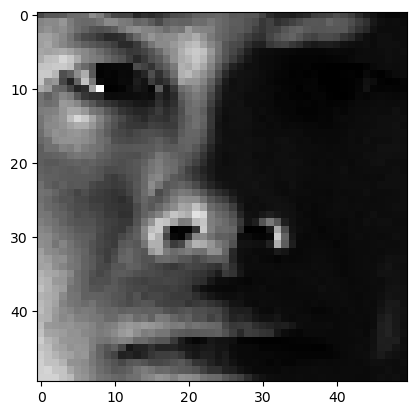

In [3]:
#Do the same for the test set.
#Size of matrix Xtest should be 100 x 2500


test_labels, test_data = [], []
for line in open('test.txt'):
    im = cv2.imread(line.strip().split()[0],0)
    test_data.append(im.reshape(2500,))
    test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)
print (test_data.shape, test_labels.shape)
plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

## Average Face

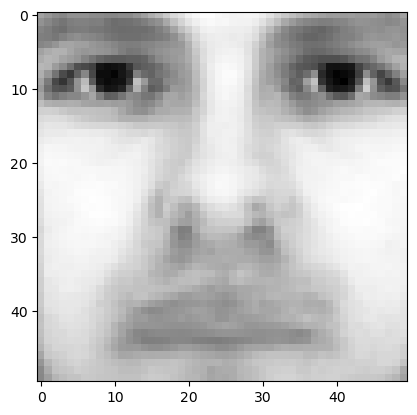

In [4]:
#Compute average face u from whole training set by [sum(rows of X)/ (# of faces)]
#Display the average face as a grayscale image
avg = np.sum(train_data,axis=0) / train_data.shape[0]
plt.imshow(avg.reshape(50,50), cmap = cm.Greys_r)
plt.show()

## Mean Subtraction

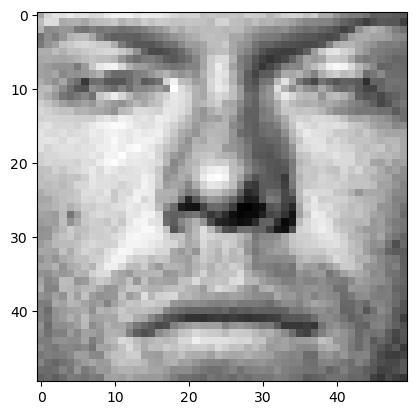

In [5]:
#Subtract average face u from every row in X (xi = xi-u)
#Pick a face image after mean substraction and display in grayscale
#Repeat same step with Xtest using precomputed average face u [part c]

train_data = train_data - avg
test_data = test_data - avg

plt.imshow(train_data[10,:].reshape(50,50), cmap = cm.Greys_r)
plt.show()

## Eigenface

(540, 540)


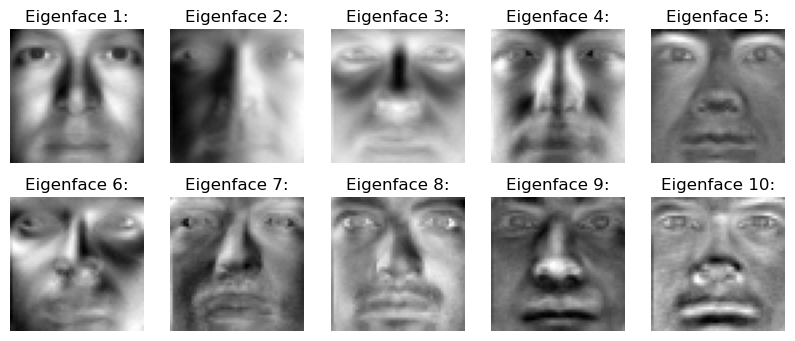

In [6]:
#Perform eigendecomposition 
#Display the first 10 eigenfaces as 1- images in grayscale
# acquire the covariance matrix (X*XT/n)
covarianceMatrix = np.matmul(train_data, train_data.T)/train_data.shape[0]
print(covarianceMatrix.shape)

# compute eigenvectors
def getEigenvectors(covarianceMatrix):
    evalues, evectors= np.linalg.eigh(covarianceMatrix)

    # sort eigenvectors by their corresponding eigenvalues (from max to min)
    # credit to following code (modified it slightly such that I only compute data I need):
    # https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
    
    i = evalues.argsort()[::-1]
    return evectors[:,i]




# returns n eigenfaces, in which each row is an eigenface. Dimensinos are n x 65536. 
def getEigenFaces(n,eigenVectors):

    # instantiate empty np array 
    eigenFaces = np.empty((n,2500), float)

    # iterate through each eigenvector and set each eigenface (ef_i) to the normalized vector of XT * v_i
    for i in range(n):
        eigenFaces[i] = np.matmul(train_data.T, eigenVectors[i])     # compute xT * v_i
        #eigenFaces[i] = eigenFaces[i]/np.linalg.norm(eigenFaces[i]) # normalization (divide by magnitude)

    return eigenFaces


# displays exactly 10 eigenfaces. Assumes eigenfaces input is exactly 10 eigenfaces. 
def displayEigenFaces(eigenfaces):

    #set a reasonable size to hold images on plot
    eigenFacePlot = plt.figure(figsize=(10,4)) 

    # iterate through each eigenface and add it to the plot. 
    # display 5 eigenfaces per row on the plot 
    for i in range(10):
        eigenFacePlot.add_subplot(2, 5, i+1)    #this allows for displaying each image by rotating in a 'clockwise' manner around the plot
        plt.imshow(np.array(eigenfaces[i].reshape(50, 50)), cmap = 'gray')    #plot the eigenface
        plt.axis('off')                 
        plt.title('Eigenface ' + str(i+1) + ':')    #label the eigenface
        
        
eigenVectors = getEigenvectors(covarianceMatrix).T
eigen_faces = getEigenFaces(train_data.shape[0],eigenVectors)
displayEigenFaces(eigen_faces)

## Eigenface Feature and Dimentionality reduction

In [7]:
def dim_red(X_meaned , num_components):
    
    
    # calculate covariance
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    # calculate eigen cvalues
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    # sort vectors
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    # get subset
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    # reduced dims
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced

In [8]:
print("Shape of train data before Dims Red :", train_data.shape)
train_data_red = dim_red(train_data,10)
print("Shape of train data after Dims Red :", train_data_red.shape)

Shape of train data before Dims Red : (540, 2500)
Shape of train data after Dims Red : (540, 10)


In [9]:
print("Shape of test data before Dims Red :", test_data.shape)
test_data_red = dim_red(test_data,10)
print("Shape of test data after Dims Red :", test_data_red.shape)

Shape of test data before Dims Red : (100, 2500)
Shape of test data after Dims Red : (100, 10)


## Face Recognition and Logistic Regression

In [10]:
# initialize the model
model = LogisticRegression( )

# train the model
model .fit(train_data_red, train_labels)

# get model preds
preds = model.predict(train_data_red)
print("TRAIN_ACCURACY = ", accuracy_score(train_labels,preds))


preds = model.predict(test_data_red)
print("TEST_ACCURACY = ", accuracy_score(test_labels,preds))

TRAIN_ACCURACY =  0.8018518518518518
TEST_ACCURACY =  0.2


In [11]:
r= 200

train = []
test = []
for i in range(1,r+1):
   
    # reduce train _dims
    train_data_red = dim_red(train_data,i)
    
    # reduce test _dims
    test_data_red = dim_red(test_data,i)
    
    # initialize the model
    model = LogisticRegression( multi_class= 'ovr')
    
    # train the model
    model.fit(train_data_red,train_labels)
    
    #get model preds
    preds = model.predict(train_data_red)
    train.append(accuracy_score(train_labels,preds))

    preds = model.predict(test_data_red)
    test.append(accuracy_score(test_labels,preds))


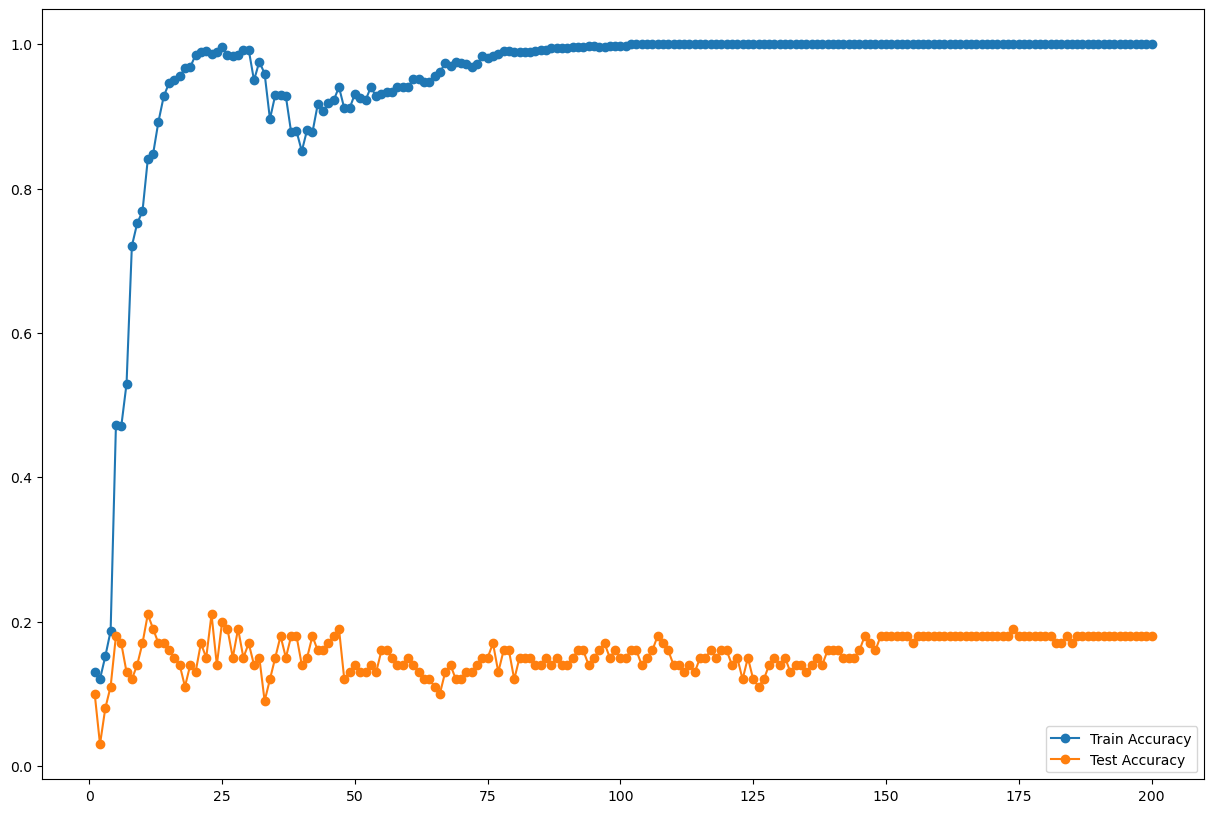

In [12]:
#Plot classification accuracy on the test set as a function of r 
x= [i for i in range(1,r+1)]
#print(x)
plt.figure(figsize=(15,10))
plt.plot(x,train,'-o',label="Train Accuracy")
plt.plot(x,test,'-o',label="Test Accuracy")
plt.legend()
plt.show()


# Part 2: Implement EM algorithm

In [61]:
#loading the datasets
X = pd.read_csv('faithful.csv')
X = X.drop('Unnamed: 0',axis=1)
X

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
...,...,...
267,4.117,81
268,2.150,46
269,4.417,90
270,1.817,46


## Plot the data

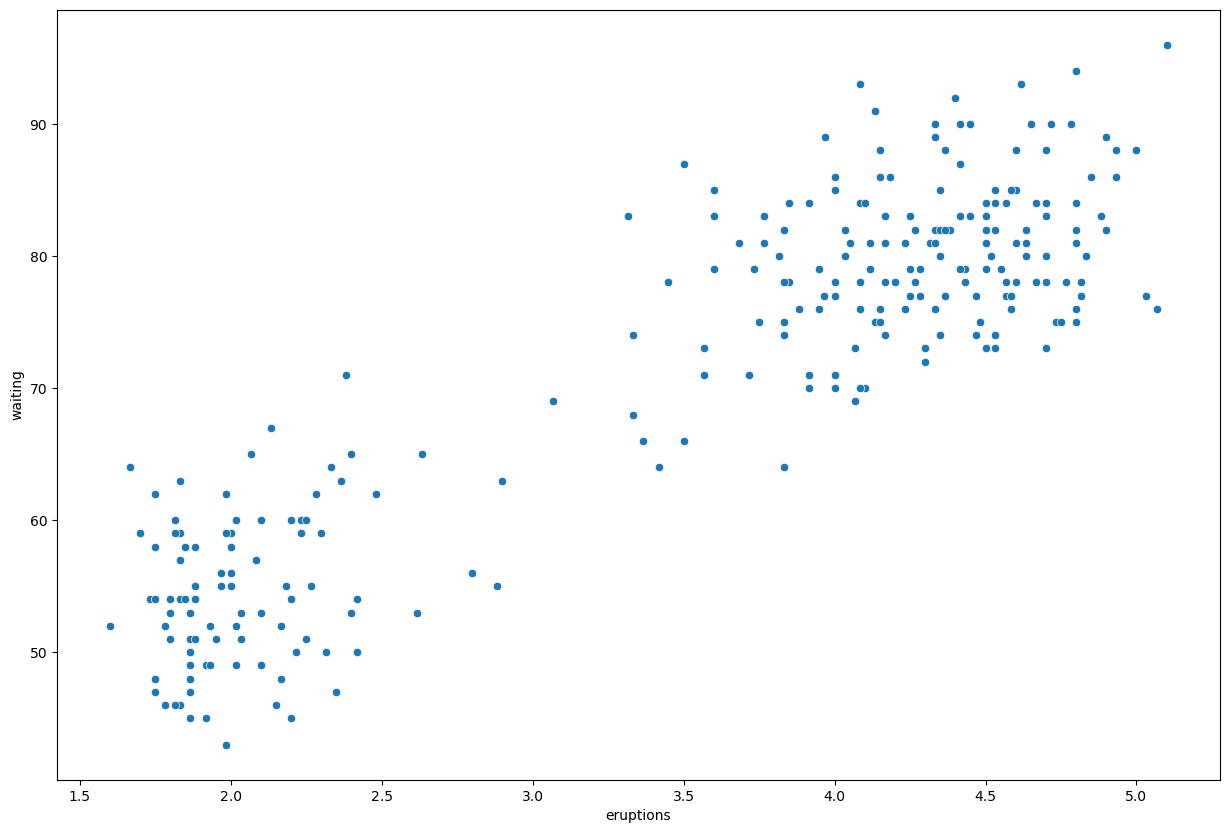

In [62]:
plt.figure(figsize = (15,10))
sns.scatterplot(data=X, x="eruptions", y="waiting")
plt.show()

## Scaling the dataset

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled,columns=['eruptions','waiting'])
X

,eruptions,waiting
0,0.098499,0.597123
1,-1.481459,-1.245181
2,-0.135861,0.228663
3,-1.057503,-0.655644
4,0.917443,1.039277
...,...,...
267,0.552298,0.744508
268,-1.174245,-1.834719
269,0.815624,1.407737
270,-1.466537,-1.834719


# EM ALGORITHM
- Termination condition is based on the error. if the error reduced to the given value the program will be terminated by default value is 0.0001 so we got minimum error in the clusters.

In [64]:
# function for calculating the denominator for posterior probabilities
def calculateDenominator(x,params,k):
    sum = 0
    for i in range(k):
        mu = np.array(params[i]['mu'+str(i)])
        mu = mu[~np.isnan(mu)]
        sum+= ((multivariate_normal.pdf(x,mean=mu,cov=params[i]['cov'+str(i)],allow_singular=True) * params[i]['prior'+str(i)]))
    return sum

In [65]:
def EM_Algorithm(data,k,eps=0.0001):
    # Initialization of the parameters
    params = []
    params_old = []        # empty params list to keep track of previous means to apply early stopping

    for i in range(k):
        # np.random.seed(i*10)
        a = np.random.randint(0,len(data))
        cov = np.zeros((data.shape[1],data.shape[1]))
        np.fill_diagonal(cov,i+1)
        params.append({'mu'+str(i):np.array(data.iloc[a].values),'cov'+str(i) :cov ,'prior'+str(i):(1/k)})
    print(params)

    #expectation step :
    epsilon = 100
    x_dim = data.columns.shape[0]
    data_cols = data.columns
    iterations = 0
    final_means = []
    
    while epsilon > eps:
        means_new = []
        for i in range(k):
            col = 'w'+str(i)
            data[col] = np.nan
            mu = np.array(params[i]['mu'+str(i)])   # mean at each k value
            mu = mu[~np.isnan(mu)]           
            cov = params[i]['cov'+str(i)]             # covariance at each k value
            prior = params[i]['prior'+str(i)] # prior at each k
            means_new.append(list(mu))

            for j in range(len(data)):
                part1 = multivariate_normal.pdf(data.iloc[j][data_cols].values,mean=mu,cov=cov,allow_singular=True)
                numerator = part1*prior
                part2 = calculateDenominator(data.iloc[j][data_cols].values,params,k)
                data.loc[j][col] = (numerator/part2)

        params_old = copy.deepcopy(params)     # storing the parameters for t-1 step
        final_means.append(means_new)
        
        #print(final_means)
        # maximization step

        for i in range(k):

            # reestimate mean
            sum1 = 0
            for j in range(len(data)):
                sum1+= data.iloc[j]['w'+str(i)] * data.iloc[j][data_cols].values
            sum2 = np.sum(data['w'+str(i)].values)
            params[i]['mu'+str(i)] = (sum1/sum2)

            # reestimate prior:
            prior = (data['w'+str(i)].values.sum()) / len(data)
            params[i]['prior'+str(i)] = prior

            # re-estimate covariance matrix:
            cov_numerator = 0
            for j in range(len(data)):
                cov_numerator += data.iloc[j]['w'+str(i)] * np.dot(data.iloc[j][data_cols].values.reshape(x_dim,1)-params[i]['mu'+str(i)].reshape(x_dim,1),(data.iloc[j][data_cols].values.reshape(x_dim,1)-params[i]['mu'+str(i)].reshape(x_dim,1)).T)
            cov_denominator = data['w'+str(i)].values.sum()
            cov = cov_numerator/cov_denominator
            params[i]['cov'+str(i)] = cov

        epsilon = 0
        for i in range(k):
            epsilon += np.linalg.norm(params[i]['mu'+str(i)].reshape(x_dim,1)-params_old[i]['mu'+str(i)].reshape(x_dim,1))  # stopping criteria
    
    final_means = np.array(final_means)
    print(final_means.shape)
    #print(final_means)
    #print(means_new)
    
    
    #### Plot the trajectories
    plt.figure()
    plt.title("TRAJECTORIES")
    for i in range(final_means.shape[2]):
        plt.plot(final_means[:,0,i], final_means[:,1,i], '-o', label = "Mean " + str(i))
    plt.legend()
    plt.show()
    
    
    return data

[{'mu0': array([0.37674691, 0.00758596]), 'cov0': array([[1., 0.],
       [0., 1.]]), 'prior0': 0.5}, {'mu1': array([0.30301557, 0.52343125]), 'cov1': array([[2., 0.],
       [0., 2.]]), 'prior1': 0.5}]
(23, 2, 2)


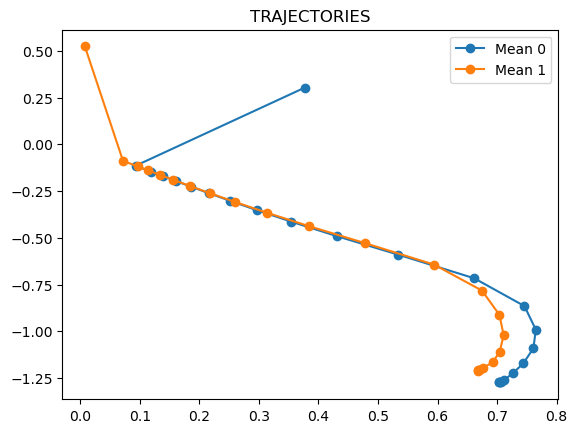

In [66]:
Z = EM_Algorithm(X,2,0.0001)   # input dataset, K, epsilon for stopping criteria

In [67]:
X['y'] = np.nan
for i in range(len(X)):
    X['y'].loc[i] = np.argmax(list(zip(Z[['w0','w1']].loc[i])))

In [68]:
output = X[['eruptions','waiting','y']]

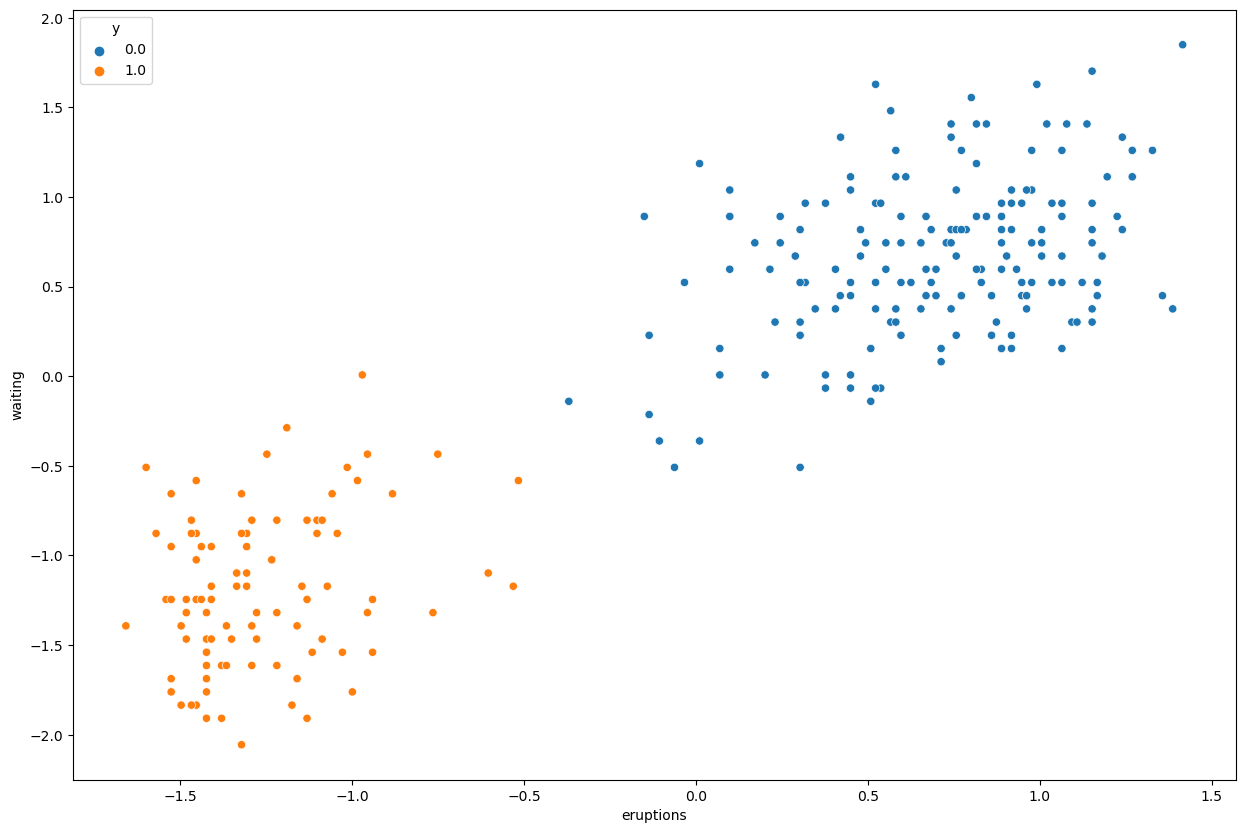

In [69]:
plt.figure(figsize = (15,10))
sns.scatterplot(data=output, x="eruptions", y="waiting", hue="y")
plt.show()

## K-Means Clustering

### Load the dataset 

In [70]:
X = pd.read_csv('faithful.csv')
X = X.drop('Unnamed: 0',axis=1)
X

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
...,...,...
267,4.117,81
268,2.150,46
269,4.417,90
270,1.817,46


### Scaling the dataset

In [71]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled,columns=['eruptions','waiting'])
X

,eruptions,waiting
0,0.098499,0.597123
1,-1.481459,-1.245181
2,-0.135861,0.228663
3,-1.057503,-0.655644
4,0.917443,1.039277
...,...,...
267,0.552298,0.744508
268,-1.174245,-1.834719
269,0.815624,1.407737
270,-1.466537,-1.834719


### K means Clustering

In [72]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
X['y'] = kmeans.labels_

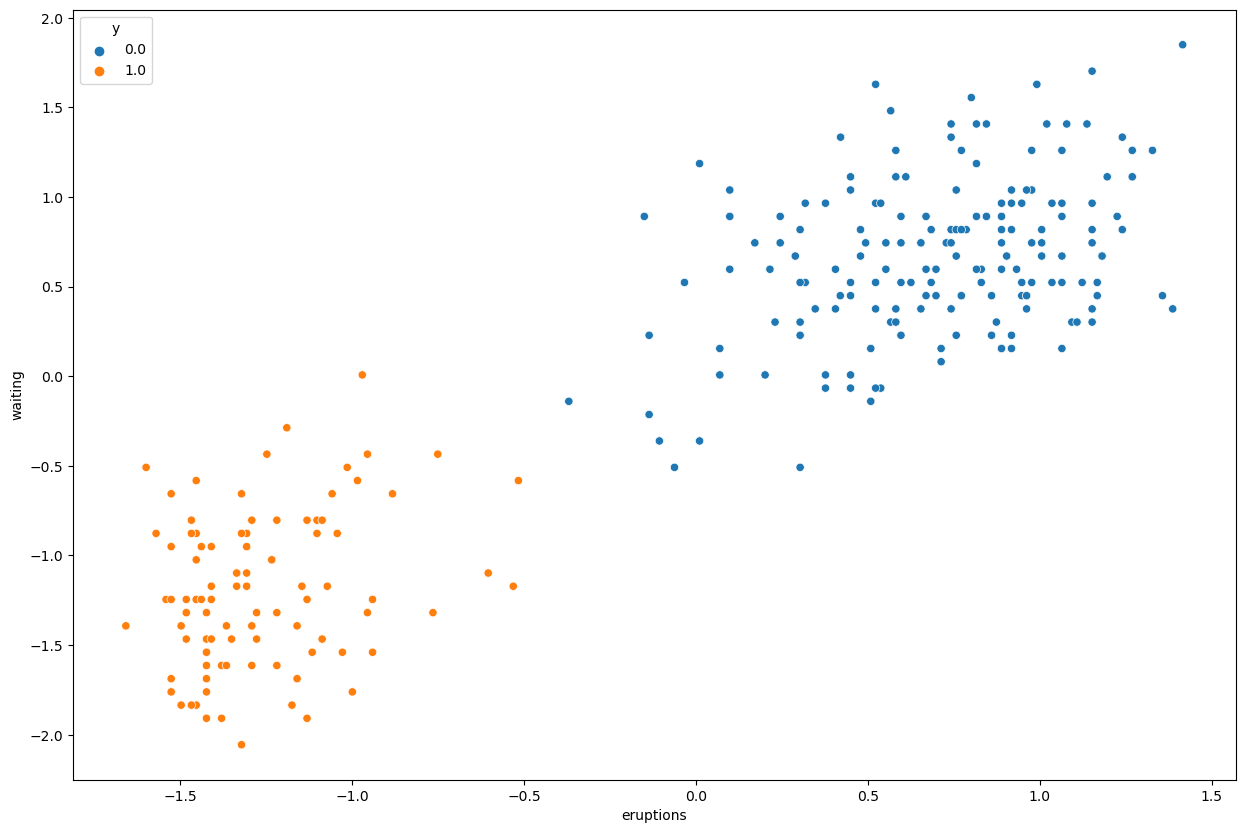

In [73]:
plt.figure(figsize = (15,10))
sns.scatterplot(data=output, x="eruptions", y="waiting", hue="y")
plt.show()

#### OBSERVATIONS:
- We got the same clusters that we have from EM algorithm.
- If the dataset is complex there are chances to have different clusters.